## Own resize multilinear

A function that implements linear interpolation for N Dimensions.

In [1]:
import tensorflow as tf
import numpy as np
import sys, os
import matplotlib.pyplot as plt
%matplotlib inline
import time

wk_dir = os.path.abspath(os.path.dirname('__file__'))

In [2]:
def _get_string_binary(number, lenght):
    number_bin = format(number, "b")
    string_binary = '0'*lenght
    string_binary = string_binary[:lenght-len(number_bin)] + number_bin
    return string_binary

In [8]:
def _get_multilinear_value(channel, position):
    """
    Calculates the interpolated value for a given position in the channel content.
    args:
        channel: A N-D Tensor [D0, D1, ..., DN-1]
        position: A 1-D float32 Tensor of N elements. Contents the position in the channel. 
    """
    N = position.shape[0]
    # Dictionary with the values around the target position and the fraction
    # of the position
    surrounds = {}
    
    # for each dimension extract the coordinates near to the position 'T'
    for d in range(N):
        integer_part = int(position[d])
        fraction_part = position[d] - integer_part
        integer_part_plus_one = min(integer_part + 1, channel.shape[d] - 1)
        
        surrounds[d] = {'0': integer_part,
                        '1': integer_part_plus_one,
                        'T': fraction_part}

    value = 0
    # for each element in the multilinear calculation
    for i in range(2**N):
        temp = 1.0
        # position of the element in the format '0000101'
        position_to_read = _get_string_binary(i, N)
        
        coordinate = []
        # l_r left or right, ic can be '0' or '1'
        for d, l_r in enumerate(reversed(range(len(position_to_read)))):
            # coordinate in the channel of the value multiplying the element 
            coordinate.append(surrounds.get(d).get(position_to_read[l_r]))
            
            # multiplication in the element
            if position_to_read[l_r] == '0':
                temp = temp * (1.0 - surrounds.get(d).get('T'))
            else:
                temp = temp * surrounds.get(d).get('T')
        
        # the element times the value at the coordinate in the channel
        temp = temp * channel.item(tuple(coordinate))
        # summing all the elements
        value = value + temp

    return int(value + 0.5)

In [9]:
# test
a = np.ones((6, 4), dtype=np.float32)
a[:, 0] = 50.0
#a[4, :] = 5.0

position = np.ones((2), dtype=np.float32)
position[0] = 0.1
position[1] = 0.1


value = get_multilinear_value(a, position)
print('value:', value)

value: 45


In [10]:
def _resize_channel_multilinear(channel, size):
    """
    Resizes content in N dimensions to size using multiliniear interpolation.
    args:
        images: An (N + 2)-D Tensor [D0, D1, ..., DN-1]
        size: A 1-D int32 Tensor of N elements: new_0D, new_1D,..new_N-1D 
    """
    N = size.shape[0]
    # This is the only code limiting N, but can be extended easily
    assert N <= 4
    assert N >= 2
    
    # new image
    #resized_channel = tf.zeros(size, dtype=tf.int32)
    resized_channel = np.zeros(size, dtype = int)
    
    scale = []
    for d in range(N):
        scale.append(float(channel.shape[d]) / float(size[d]))
    # finds positions in the original image and interpolates
    for i in range(size[0]):
        for j in range(size[1]):
            if N > 2:
                for k in range(size[2]):
                    if N > 3:
                        # Case for N = 4
                        for l in range(size[3]):
                            pass
                    else:
                        # Case for N = 3
                        pass
            else:
                # Case for N = 2
                position = np.ones((2), dtype=np.float32)
                position[0] = i * scale[0]
                position[1] = j * scale[1]
                value = _get_multilinear_value(channel, position)
                resized_channel[i, j] = value
    return resized_channel

In [11]:
a = np.ones((4, 4), dtype=np.float32)
a[:, 1] = 50.0
#a[4, :] = 5.0

size = np.ones((2), dtype=np.int32)
size[0] = 8
size[1] = 8


value = _resize_channel_multilinear(a, size)
print('value:', value)

value: [[ 1 26 50 26  1  1  1  1]
 [ 1 26 50 26  1  1  1  1]
 [ 1 26 50 26  1  1  1  1]
 [ 1 26 50 26  1  1  1  1]
 [ 1 26 50 26  1  1  1  1]
 [ 1 26 50 26  1  1  1  1]
 [ 1 26 50 26  1  1  1  1]
 [ 1 26 50 26  1  1  1  1]]


In [62]:
def resize_multilinear(content, size):
    """
    Resizes content in N dimensions to size using multiliniear interpolation.
    args:
        images: An (N + 2)-D Tensor [batch, D0, D1, ..., DN-1, channels]
        size: A 1-D int32 Tensor of N elements: new_0D, new_1D,..new_N-1D 
    """
    batches = content.shape[0]
    channels = content.shape[-1]
    
    new_size = list(content.shape)
    new_size[1:len(new_size)-1] = size
    
    # new content
    empty_resized_content = tf.Variable(tf.zeros(new_size, dtype=tf.int32))
    # resized_content = np.zeros(new_size, dtype=int)
    
    # Loop in the tensor
    def cond(batch, channel, _):
        return (channel < channels)

    def body(batch, channel, _):
        batch_i = batch.value
        channel_i = channel
        img_channel = content[batch_i,...,channel_i]
        resized_channel = _resize_channel_multilinear(img_channel, size)
        
        op = tf.assign(resized_content[batch,...,channel], resized_channel)
        
        with tf.control_dependencies([op]):
            # increment counters
            if channel == channels:
                channel_plus = 0
                batch_plus = tf.add(batch, 1)
            else:
                channel_plus = tf.add(channel, 1)
                batch_plus = batch

            return batch_plus, channel_plus, op
    
    _, _, resized_content = tf.while_loop(cond, body, [0, 0, empty_resized_content])

    
#     for batch in range(batches):
#         for channel in range(channels):
#             img_channel = content[batch, ..., channel]
#             resized_channel = _resize_channel_multilinear(img_channel, size)
            
#             # assign to the resized_content tensor
#             resized_content = resized_content[batch,...,channel].assign(resized_channel)

    return resized_content

In [63]:
# read an image and resize it
file_name = 'images/android.png'
file_path = os.path.join(wk_dir, file_name)

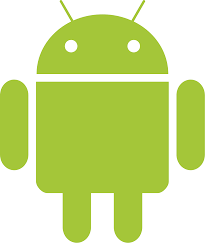

In [64]:
# Original
from IPython.display import Image
Image(file_name)

In [65]:
new_size = np.ones((2), dtype=np.int32)
new_size[0] = 100
new_size[1] = 100

# Using resize_multilinear

image_content = tf.read_file(file_path)
image_decoded = tf.image.decode_png(image_content, channels=0)
images = tf.expand_dims(image_decoded, 0)
images_resized = tf.py_func(resize_multilinear, [images, new_size], tf.int64)

start = time.time()
with tf.Session() as sess:
    tf.global_variables_initializer()
    my_result = sess.run(images_resized)
print('Execution time:', time.time() - start)
    
fig, ax = plt.subplots()
ax.imshow(my_result[0, :, :, :])
ax.axis('off')  # clear x-axis and y-axis
plt.show()

UnknownError: AttributeError: 'Tensor' object has no attribute 'value'
Traceback (most recent call last):

  File "/home/viclule/zss/image_resize_n_linear/venv/lib/python3.6/site-packages/tensorflow/python/ops/script_ops.py", line 206, in __call__
    ret = func(*args)

  File "<ipython-input-62-d88e2304ccfb>", line 41, in resize_multilinear
    _, _, resized_content = tf.while_loop(cond, body, [0, 0, empty_resized_content])

  File "/home/viclule/zss/image_resize_n_linear/venv/lib/python3.6/site-packages/tensorflow/python/ops/control_flow_ops.py", line 3291, in while_loop
    return_same_structure)

  File "/home/viclule/zss/image_resize_n_linear/venv/lib/python3.6/site-packages/tensorflow/python/ops/control_flow_ops.py", line 3004, in BuildLoop
    pred, body, original_loop_vars, loop_vars, shape_invariants)

  File "/home/viclule/zss/image_resize_n_linear/venv/lib/python3.6/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2939, in _BuildLoop
    body_result = body(*packed_vars_for_body)

  File "<ipython-input-62-d88e2304ccfb>", line 23, in body
    batch_i = batch.value

AttributeError: 'Tensor' object has no attribute 'value'


	 [[node PyFunc_13 (defined at <ipython-input-65-a5d31db2842e>:10)  = PyFunc[Tin=[DT_UINT8, DT_INT32], Tout=[DT_INT64], token="pyfunc_13", _device="/job:localhost/replica:0/task:0/device:CPU:0"](ExpandDims_14, PyFunc_13/input_1)]]

Caused by op 'PyFunc_13', defined at:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/viclule/zss/image_resize_n_linear/venv/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/viclule/zss/image_resize_n_linear/venv/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/viclule/zss/image_resize_n_linear/venv/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/viclule/zss/image_resize_n_linear/venv/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 427, in run_forever
    self._run_once()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 1440, in _run_once
    handle._run()
  File "/usr/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/viclule/zss/image_resize_n_linear/venv/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/home/viclule/zss/image_resize_n_linear/venv/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/viclule/zss/image_resize_n_linear/venv/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/home/viclule/zss/image_resize_n_linear/venv/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/viclule/zss/image_resize_n_linear/venv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/viclule/zss/image_resize_n_linear/venv/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/viclule/zss/image_resize_n_linear/venv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/viclule/zss/image_resize_n_linear/venv/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/viclule/zss/image_resize_n_linear/venv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/viclule/zss/image_resize_n_linear/venv/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/viclule/zss/image_resize_n_linear/venv/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/viclule/zss/image_resize_n_linear/venv/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/viclule/zss/image_resize_n_linear/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/viclule/zss/image_resize_n_linear/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/home/viclule/zss/image_resize_n_linear/venv/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/viclule/zss/image_resize_n_linear/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/viclule/zss/image_resize_n_linear/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/viclule/zss/image_resize_n_linear/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-65-a5d31db2842e>", line 10, in <module>
    images_resized = tf.py_func(resize_multilinear, [images, new_size], tf.int64)
  File "/home/viclule/zss/image_resize_n_linear/venv/lib/python3.6/site-packages/tensorflow/python/ops/script_ops.py", line 457, in py_func
    func=func, inp=inp, Tout=Tout, stateful=stateful, eager=False, name=name)
  File "/home/viclule/zss/image_resize_n_linear/venv/lib/python3.6/site-packages/tensorflow/python/ops/script_ops.py", line 281, in _internal_py_func
    input=inp, token=token, Tout=Tout, name=name)
  File "/home/viclule/zss/image_resize_n_linear/venv/lib/python3.6/site-packages/tensorflow/python/ops/gen_script_ops.py", line 129, in py_func
    "PyFunc", input=input, token=token, Tout=Tout, name=name)
  File "/home/viclule/zss/image_resize_n_linear/venv/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/viclule/zss/image_resize_n_linear/venv/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/home/viclule/zss/image_resize_n_linear/venv/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/home/viclule/zss/image_resize_n_linear/venv/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

UnknownError (see above for traceback): AttributeError: 'Tensor' object has no attribute 'value'
Traceback (most recent call last):

  File "/home/viclule/zss/image_resize_n_linear/venv/lib/python3.6/site-packages/tensorflow/python/ops/script_ops.py", line 206, in __call__
    ret = func(*args)

  File "<ipython-input-62-d88e2304ccfb>", line 41, in resize_multilinear
    _, _, resized_content = tf.while_loop(cond, body, [0, 0, empty_resized_content])

  File "/home/viclule/zss/image_resize_n_linear/venv/lib/python3.6/site-packages/tensorflow/python/ops/control_flow_ops.py", line 3291, in while_loop
    return_same_structure)

  File "/home/viclule/zss/image_resize_n_linear/venv/lib/python3.6/site-packages/tensorflow/python/ops/control_flow_ops.py", line 3004, in BuildLoop
    pred, body, original_loop_vars, loop_vars, shape_invariants)

  File "/home/viclule/zss/image_resize_n_linear/venv/lib/python3.6/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2939, in _BuildLoop
    body_result = body(*packed_vars_for_body)

  File "<ipython-input-62-d88e2304ccfb>", line 23, in body
    batch_i = batch.value

AttributeError: 'Tensor' object has no attribute 'value'


	 [[node PyFunc_13 (defined at <ipython-input-65-a5d31db2842e>:10)  = PyFunc[Tin=[DT_UINT8, DT_INT32], Tout=[DT_INT64], token="pyfunc_13", _device="/job:localhost/replica:0/task:0/device:CPU:0"](ExpandDims_14, PyFunc_13/input_1)]]


Execution time: 0.00947260856628418


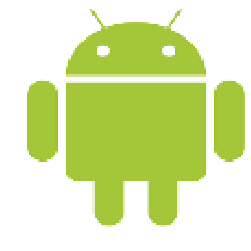

In [61]:
# Using tf.image.resize_bilinear

image_content = tf.read_file(file_path)
image_decoded = tf.image.decode_png(image_content, channels=0)
images = tf.expand_dims(image_decoded, 0)
images_resized = tf.image.resize_bilinear(images, new_size)
images_resized_int = tf.cast(images_resized, tf.int32)

start = time.time()
with tf.Session() as sess:
    tf_result = sess.run(images_resized_int)
print('Execution time:', time.time() - start)

fig, ax = plt.subplots()
ax.imshow(tf_result[0, :, :, :])
ax.axis('off')  # clear x-axis and y-axis
plt.show()

#### Differences

In [12]:
diff = my_result[0, :, :, :] - tf_result[0, :, :, :]

In [13]:
diff[:,:,:].max()

1

There is most probably an error in how floats get rounded to int